# TP2 Reinforcement Learning : Bandits

#### Jourdan Pierre-Eliot

In this notebook, feel free to modify and test different values of the parameters ($\alpha$, c, T, $\epsilon$ ...).

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [83]:
## Default parameters :

nb_episodes = 1000
nb_experiences = 2000
nb_arms = 10

P = np.random.rand(nb_arms)
best_choice = np.argmax(P)
eps = 0.1


## 1. Basic Algorithms

In this part we will study 3 first policies to solve the bandit problem : $\epsilon$-greedy, optimistic greedy and UCB.

### Question 1:

In this question, we want to plot the corresponding mean reward, the mean cumulative reward and the percentage of times
the best arm was elected as time goes by (number of episodes) for all 3 policies.

#### $\epsilon$-greedy method

In [60]:
## Algo 1 : eps-greedy        

def epsilon_greedy(nb_ep = nb_episodes, nb_exp = nb_experiences,epsilon = eps):
    
    bad_choices = np.zeros(nb_ep)
    good_choices = np.zeros(nb_ep)

    ACTIONS_TABLE = -np.ones((nb_exp, nb_ep))
    REWARDS_TABLE = np.zeros((nb_exp, nb_ep))

    for e in range(nb_exp):
        rewards = np.zeros(nb_arms)
        num = np.ones(nb_arms)*0.0000001
        for t in range(nb_ep):
            if np.random.rand() <= epsilon:
                ind = np.random.randint(nb_arms)
            else :
                ind = np.argmax(rewards / num)
            if ind != best_choice:
                bad_choices[t] += 1
            else:
                good_choices[t] += 1
            
            reward = np.random.rand() <= P[ind]
            rewards[ind] += reward
            num[ind] += 1
            
            ACTIONS_TABLE[e, t] = ind
            REWARDS_TABLE[e, t] = reward
    percentages = 100*np.mean(np.cumsum(ACTIONS_TABLE == best_choice, axis=1), axis=0) / np.arange(1, nb_ep+1)
    return ACTIONS_TABLE,REWARDS_TABLE,percentages


We define the following function to compute the mean cumulative reward from the mean reward values :

In [61]:
def mean_cumulative_rewards(mean_rewards) :
    result = np.arange(1, nb_episodes+1) - np.cumsum(mean_rewards)
    return result

Text(0.5, 0, 'Number of episodes')

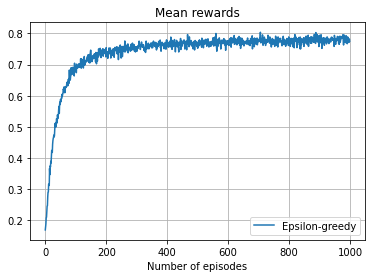

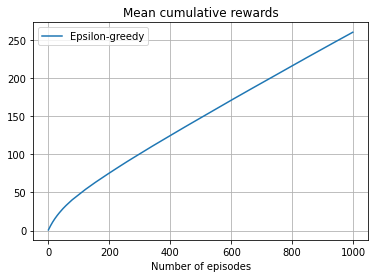

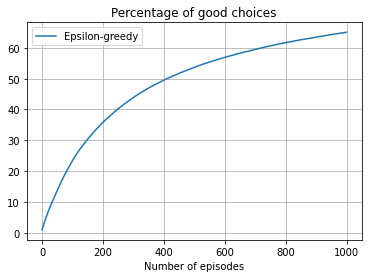

In [62]:
A_eps,R_eps,percentages_eps = epsilon_greedy()
mean_rewards_eps = np.mean(R_eps, axis=0)

plt.figure()
plt.title('Mean rewards')
plt.plot(mean_rewards_eps, label="Epsilon-greedy")
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')

plt.figure()
plt.title('Mean cumulative rewards')
plt.plot(mean_cumulative_rewards(mean_rewards_eps), label="Epsilon-greedy")
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')

plt.figure()
plt.title('Percentage of good choices')
plt.plot(percentages_eps, label="Epsilon-greedy")
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')


#### Decaying $\epsilon_t$-greedy algorithm

In order to study the effect of the parameter $\epsilon$, we can plot the evolution of the $\epsilon_t$-greedy algorithm.

In [63]:
# Parameters
cst = 0.1
delta = 1
it = 4 # nb of different values for epsilon

mean_rewards_list = np.zeros((it,nb_episodes))
for t in range(it):
    epsilon_t = cst*nb_arms/(delta*(t+1))
    A_eps,R_eps,percentages_eps = epsilon_greedy(nb_episodes, nb_experiences, epsilon_t)
    mean_rewards_list[t] = np.mean(R_eps, axis=0)


Text(0, 0.5, 'Mean reward')

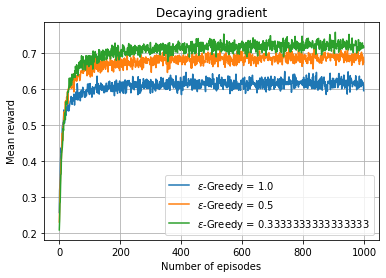

In [64]:
plt.figure()
plt.title('Decaying gradient')
for t in range(1,it):
    k = c*nb_arms/(delta*t)
    plt.plot(range(nb_episodes),mean_rewards_list[t,:],label='$\epsilon$-Greedy = {k}'.format(k=k))
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')
plt.ylabel('Mean reward')

We notice that the value of the mean reward increases when $\epsilon$ get smaller.

#### Optimistic greedy method

In [65]:
## Algo 2 : Optimistic greedy            

def optimistic_greedy(nb_ep = nb_episodes, nb_exp = nb_experiences,q0 = 100):
    bad_choices = np.zeros(nb_ep)
    good_choices = np.zeros(nb_ep)

    ACTIONS_TABLE = -np.ones((nb_exp, nb_ep))
    REWARDS_TABLE = np.zeros((nb_exp, nb_ep))

    for e in range(nb_exp):
        q_value = np.ones(nb_arms)*q0
        num = np.ones(nb_arms)*0.0000001

        for t in range(nb_ep):
            ind = np.argmax(q_value)
            if ind != best_choice:
                bad_choices[t] += 1
            else:
                good_choices[t] += 1
            
            reward = np.random.rand() <= P[ind]
            num[ind] += 1
            q_value[ind] += (reward-q_value[ind])/num[ind]
            best_arm = np.argmax(q_value)

            ACTIONS_TABLE[e, t] = ind
            REWARDS_TABLE[e, t] = reward
    percentages = 100*np.mean(np.cumsum(ACTIONS_TABLE == best_choice, axis=1), axis=0) / np.arange(1, nb_ep+1)
    return ACTIONS_TABLE,REWARDS_TABLE,percentages


Text(0.5, 0, 'Number of episodes')

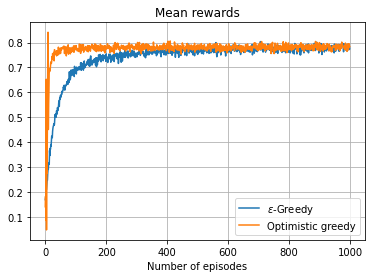

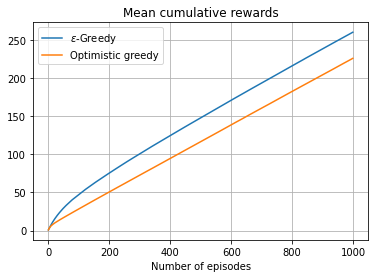

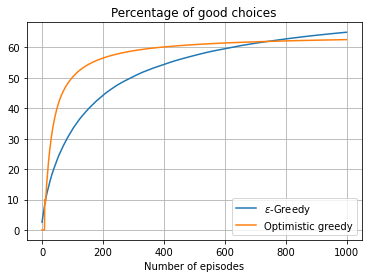

In [66]:
A_opt,R_opt,percentages_opt = optimistic_greedy()
mean_rewards_opt = np.mean(R_opt, axis=0)

plt.figure()
plt.title('Mean rewards')
plt.plot(mean_rewards_eps,label='$\epsilon$-Greedy')
plt.plot(mean_rewards_opt,label='Optimistic greedy')
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')

plt.figure()
plt.title('Mean cumulative rewards')
plt.plot(mean_cumulative_rewards(mean_rewards_eps),label='$\epsilon$-Greedy')
plt.plot(mean_cumulative_rewards(mean_rewards_opt),label='Optimistic greedy')
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')

plt.figure()
plt.title('Percentage of good choices')
plt.plot(percentages_eps,label='$\epsilon$-Greedy')
plt.plot(percentages_opt,label='Optimistic greedy')
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')

#### Upper Confidence Bounds (UCB)

In [67]:
## Algo 3 : UCB                   

def ucb(nb_ep = nb_episodes, nb_exp = nb_experiences,c=2):

    bad_choices = np.zeros(nb_ep)
    good_choices = np.zeros(nb_ep)

    ACTIONS_TABLE = -np.ones((nb_exp, nb_ep))
    REWARDS_TABLE = np.zeros((nb_exp, nb_ep))

    for e in range(nb_exp):
        rewards = np.zeros(nb_arms)
        num = np.ones(nb_arms)*0.0000001

        for t in range(nb_ep):
            epsilon_list = np.sqrt(c*np.log(t+1)/(num+0.0001))
            ind = np.argmax(rewards / num + epsilon_list)
            if ind != best_choice:
                bad_choices[t] += 1
            else:
                good_choices[t] += 1
            
            reward = np.random.rand() <= P[ind]
            num[ind] += 1
            rewards[ind] += reward

            ACTIONS_TABLE[e, t] = ind
            REWARDS_TABLE[e, t] = reward
    percentages = 100*np.mean(np.cumsum(ACTIONS_TABLE == best_choice, axis=1), axis=0) / np.arange(1, nb_ep+1)
    return ACTIONS_TABLE,REWARDS_TABLE,percentages


Text(0.5, 0, 'Number of episodes')

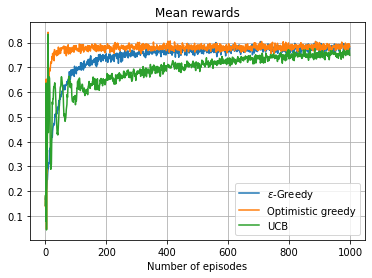

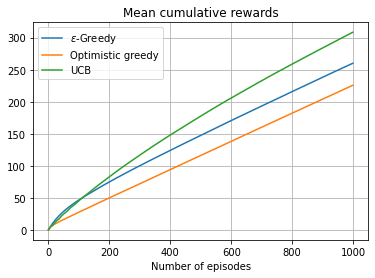

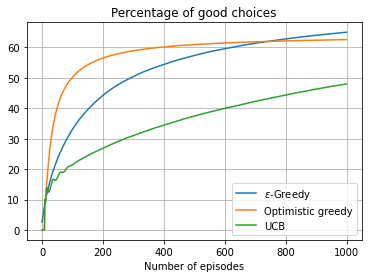

In [68]:
A_ucb,R_ucb,percentages_ucb = ucb()
mean_rewards_ucb = np.mean(R_ucb, axis=0)

plt.figure()
plt.title('Mean rewards')
plt.plot(mean_rewards_eps,label='$\epsilon$-Greedy')
plt.plot(mean_rewards_opt,label='Optimistic greedy')
plt.plot(mean_rewards_ucb,label='UCB')
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')

plt.figure()
plt.title('Mean cumulative rewards')
plt.plot(mean_cumulative_rewards(mean_rewards_eps),label='$\epsilon$-Greedy')
plt.plot(mean_cumulative_rewards(mean_rewards_opt),label='Optimistic greedy')
plt.plot(mean_cumulative_rewards(mean_rewards_ucb),label='UCB')
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')

plt.figure()
plt.title('Percentage of good choices')
plt.plot(percentages_eps,label='$\epsilon$-Greedy')
plt.plot(percentages_opt,label='Optimistic greedy')
plt.plot(percentages_ucb,label='UCB')
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')

We notice that for bigger values of T (number of episodes > 3000), the UCB solution seems to provide better results than the 2 others.

### Question 2:

Let's plot the asymptotic proba of taking the optimal action.


Text(0.5, 0, 'Number of episodes')

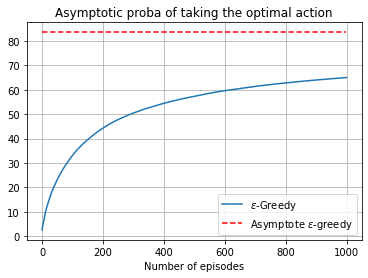

In [81]:
asymptotic_eps = max(P) # 1-2*eps + eps/nb_arms

plt.figure()
plt.title('Asymptotic proba of taking the optimal action')
plt.plot(percentages_eps,label='$\epsilon$-Greedy')
plt.plot(range(nb_episodes), [100*asymptotic_eps for i in range(nb_episodes)], 'r--', label="Asymptote $\epsilon$-greedy")
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')


### Question 3:

Let's plot, for the $\epsilon$-greedy method, the mean reward obtained as a function of $\epsilon$ and for different number of episodes (T).

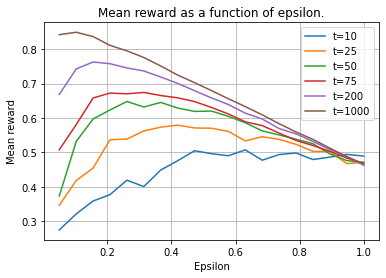

In [84]:
# Epsilon - Greedy

epsilon_list = np.linspace(0.05, 1.0, 19)
for t in [10, 25, 50, 75, 200,1000]:
    mean_rewards = []
    for e in epsilon_list:
        _, R, _ = epsilon_greedy(t, 200, e)
        mean_rewards.append(np.mean(np.sum(R, axis=1)) / t)
    plt.plot(epsilon_list, mean_rewards, label=f"t={t}")
plt.legend()
plt.grid()
plt.title("Mean reward as a function of epsilon.")
plt.xlabel("Epsilon")
plt.ylabel("Mean reward")
plt.show()

As shown on the figure, for large T, it is preferable to choose a value close to 0 for $\epsilon$ (like 0.1 for instance). On the other hand, for a small T, it is best to choose a value close to 1 for $\epsilon$ (like 0.8 for instance).

### Question 4:

We notice there are some spikes in the plot of the average (mean) rewards of all three methods when the number of episodes t is very small. This is due to the fact that we randomly choose an arm at the beginning (for the first experiences), since we haven't explored all the solutions yet. Therefore, for the first episode, we will observe a spike for the average reward due to this random selection of the arm.

### Question 5: 
cf Question 1

### Question 6: Conclusion

Which method is best ? According to the previous results, it seems that when T goes to infinity, the UCB method is the more performant as both its mean reward and mean cumulative reward are converging towards higher values than for the 2 other methods. As well, its percentage of time the best arm was selected gets better when T increases.

## 2. Gradient method

In this part of the TP we will implement the gradient bandit algorithm. We will consider 2 cases : with or without baseline ($R = 4 \times \max_k p_k$  or $R=0$).
We will also take different values for the $\alpha$ parameter ($\alpha_n = \alpha_0/n$).


In [75]:
def gradient_bandit(nb_ep = nb_episodes, nb_exp = nb_experiences, alpha=0.1, basel='without'):

    bad_choices = np.zeros(nb_ep)
    good_choices = np.zeros(nb_ep)

    ACTIONS_TABLE = -np.ones((nb_exp, nb_ep))
    REWARDS_TABLE = np.zeros((nb_exp, nb_ep))

    for e in range(nb_exp):
        h = np.zeros(nb_arms)
        rewards = np.zeros(nb_ep)
        for t in range(nb_ep):
            prob = np.exp(h) / np.sum(np.exp(h))
            ind = np.random.choice(nb_arms, p = prob)
            if basel == 'without':
                baseline = 0 
            elif basel == 'with':
                baseline = 4*np.max(prob)

            # if ind != best_choice:
            #     bad_choices[t] += 1
            # else:
            #     good_choices[t] += 1

            reward = (np.random.rand() <= P[ind])
            rewards += reward
            h[ind] += alpha * (reward - baseline) * (1 - prob[ind])
            
            ACTIONS_TABLE[e, t] = ind
            REWARDS_TABLE[e, t] = reward
    percentages = 100*np.mean(np.cumsum(ACTIONS_TABLE == best_choice, axis=1), axis=0) / np.arange(1, nb_ep+1)
    return ACTIONS_TABLE, REWARDS_TABLE, percentages


Let's plot the evolution of the mean, mean cumulative reward and percentage of time the best arm was selected for the gradient method. Let's compare them with the ones obtained for the 3 first policies. 

Text(0.5, 0, 'Number of episodes')

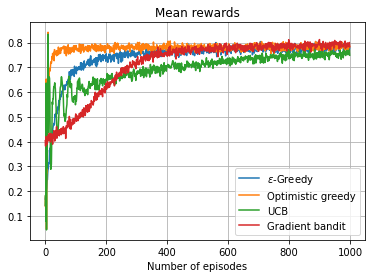

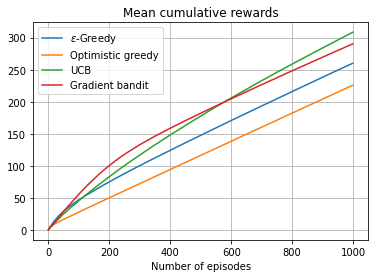

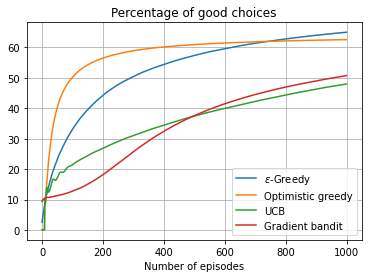

In [76]:
A_grad, R_grad, percentages_grad = gradient_bandit()
mean_rewards_grad = np.mean(R_grad, axis=0)

plt.figure()
plt.title('Mean rewards')
plt.plot(mean_rewards_eps,label='$\epsilon$-Greedy')
plt.plot(mean_rewards_opt,label='Optimistic greedy')
plt.plot(mean_rewards_ucb,label='UCB')
plt.plot(mean_rewards_grad,label='Gradient bandit')
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')

plt.figure()
plt.title('Mean cumulative rewards')
plt.plot(mean_cumulative_rewards(mean_rewards_eps),label='$\epsilon$-Greedy')
plt.plot(mean_cumulative_rewards(mean_rewards_opt),label='Optimistic greedy')
plt.plot(mean_cumulative_rewards(mean_rewards_ucb),label='UCB')
plt.plot(mean_cumulative_rewards(mean_rewards_grad),label='Gradient bandit')
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')

plt.figure()
plt.title('Percentage of good choices')
plt.plot(percentages_eps,label='$\epsilon$-Greedy')
plt.plot(percentages_opt,label='Optimistic greedy')
plt.plot(percentages_ucb,label='UCB')
plt.plot(percentages_grad,label='Gradient bandit')
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')

Text(0.5, 0, 'Number of episodes')

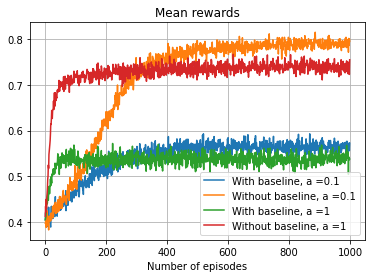

In [77]:
alpha = [0.1, 1]
plt.figure()
plt.title('Mean rewards')
for i in range(len(alpha)):
    x = alpha[i]
    A_grad_w, R_grad_w, percentages_grad_w = gradient_bandit(nb_episodes,nb_experiences,x,'with')
    A_grad_wo, R_grad_wo, percentages_grad_wo = gradient_bandit(nb_episodes,nb_experiences,x,'without')    
    mean_rewards_grad_w = np.mean(R_grad_w, axis=0)
    mean_rewards_grad_wo = np.mean(R_grad_wo, axis=0)
    plt.plot(mean_rewards_grad_w,label='With baseline, a ={x}'.format(x=x))
    plt.plot(mean_rewards_grad_wo,label='Without baseline, a ={x}'.format(x=x))
plt.legend()
plt.grid()
plt.xlabel('Number of episodes')


# plt.figure()
# plt.title('Mean cumulative rewards')
# plt.plot(mean_cumulative_rewards(mean_rewards_eps),label='$\epsilon$-Greedy')
# plt.plot(mean_cumulative_rewards(mean_rewards_opt),label='Optimistic greedy')
# plt.plot(mean_cumulative_rewards(mean_rewards_ucb),label='UCB')
# plt.plot(mean_cumulative_rewards(mean_rewards_grad),label='Gradient bandit')
# plt.legend()
# plt.xlabel('Number of episodes')

# plt.figure()
# plt.title('Percentage of good choices')
# plt.plot(percentages_eps,label='$\epsilon$-Greedy')
# plt.plot(percentages_opt,label='Optimistic greedy')
# plt.plot(percentages_ucb,label='UCB')
# plt.plot(percentages_grad,label='Gradient bandit')
# plt.legend()
# plt.xlabel('Number of episodes')

### Question 1:

According to the plot of the last figure, we notice the method without baseline works surprisingly better than the one with baseline. 
We can also estimate the influence of the $\alpha$ parameter : for higher values, the mean reward wil converge faster.

### Question 2:

When we compare the performance of the gradient method with the others (see figure above), we remark it gives a better mean reward than the $\epsilon$-greedy method but not as high as the two others (we need to take big values of T to observe that). Its percentage of time it selected the best arm seems very close to the one of UCB, which is a good result. 

## 3. Parameter study by Learning curve

In this last part, we will compare in a systematic way the performance of all policies. To do this, we will plot the average reward obtained for $T = 1000$ and for all policies as a function of the parameters of each method : $\epsilon$, $Q_0$, c and $\alpha$.

### Question 1:

([<matplotlib.axis.XTick at 0x266e05d8c40>,
 [Text(0, 0, '1/128'),
  Text(1, 0, '1/64'),
  Text(2, 0, '1/32'),
  Text(3, 0, '1/16'),
  Text(4, 0, '1/8'),
  Text(5, 0, '1/4'),
  Text(6, 0, '1/2'),
  Text(7, 0, '1'),
  Text(8, 0, '2'),
  Text(9, 0, '4')])

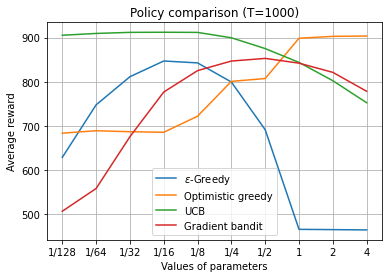

In [85]:
parameters = [2**i for i in range(-7,3)]
mean_rewards_eps_final = []
mean_rewards_opt_final = []
mean_rewards_ucb_final = []
mean_rewards_grad_final = []

for i in range(len(parameters)):
    A_eps_f,R_eps_f,percentages_eps_f = epsilon_greedy(nb_episodes,nb_experiences,parameters[i])
    A_opt_f,R_opt_f,percentages_opt_f = optimistic_greedy(nb_episodes,nb_experiences,parameters[i])
    A_ucb_f,R_ucb_f,percentages_ucb_f = ucb(nb_episodes,nb_experiences,parameters[i])
    A_grad_f, R_grad_f, percentages_grad_f = gradient_bandit(nb_episodes,nb_experiences,parameters[i],'without')

    mean_rewards_eps_final.append(np.mean(np.sum(R_eps_f, axis=1)))
    mean_rewards_opt_final.append(np.mean(np.sum(R_opt_f, axis=1)))
    mean_rewards_ucb_final.append(np.mean(np.sum(R_ucb_f, axis=1)))
    mean_rewards_grad_final.append(np.mean(np.sum(R_grad_f, axis=1)))

plt.figure()
plt.title('Policy comparison (T=1000)')
plt.plot(mean_rewards_eps_final,label='$\epsilon$-Greedy')
plt.plot(mean_rewards_opt_final,label='Optimistic greedy')
plt.plot(mean_rewards_ucb_final,label='UCB')
plt.plot(mean_rewards_grad_final,label='Gradient bandit')
plt.legend()
plt.grid()
plt.xlabel('Values of parameters')
plt.ylabel('Average reward')
plt.xticks(range(10),['1/128','1/64','1/32','1/16','1/8','1/4','1/2','1','2','4'])


In [86]:
max_eps = np.max(mean_rewards_eps_final)
max_opt = np.max(mean_rewards_opt_final)
max_ucb = np.max(mean_rewards_ucb_final)
max_grad = np.max(mean_rewards_grad_final)

print('Maximum average reward for $\epsilon$-Greedy :',max_eps)
print('Maximum average reward for Optimistic Greedy :',max_opt)
print('Maximum average reward for UCB :',max_ucb)
print('Maximum average reward for Gradient bandit :',max_grad)
print(' ')
print('Mean average reward for $\epsilon$-Greedy :',np.mean(mean_rewards_eps_final))
print('Mean average reward for Optimistic Greedy :',np.mean(mean_rewards_opt_final))
print('Mean average reward for UCB :',np.mean(mean_rewards_ucb_final))
print('Mean average reward for Gradient bandit :',np.mean(mean_rewards_grad_final))



Maximum average reward for $\epsilon$-Greedy : 846.918
Maximum average reward for Optimistic Greedy : 903.462
Maximum average reward for UCB : 912.0555
Maximum average reward for Gradient bandit : 852.8045
 
Mean average reward for $\epsilon$-Greedy : 676.22
Mean average reward for Optimistic Greedy : 777.9037500000001
Mean average reward for UCB : 872.3012499999999
Mean average reward for Gradient bandit : 748.29715


The best algorithm for this example is UCB since it provides the highest maximum value and the highest mean of the average reward.

### Question 2:

We notice the curves of $\epsilon$-greedy and gradient bandit seems to be symetric in comparison to the axis $x = 1/8$. The curve of UCB for $c \le 1/8$ and the curve of Optimistic Greedy for $Q_0 \ge 1/2$ seem to have a similar behaviour.

We can print the optimal values of the parameter for each algorithm by selecting the one corresponding to the maximum of the mean reward. We get the following values :

In [87]:
eps_max = np.argmax(mean_rewards_eps_final)
q0_max = np.argmax(mean_rewards_opt_final)
c_max = np.argmax(mean_rewards_ucb_final)
alpha_max = np.argmax(mean_rewards_grad_final)

print('Optimal value for $\epsilon$ :',parameters[eps_max])
print('Optimal value for $Q_0$ :',parameters[q0_max])
print('Optimal value for c :',parameters[c_max])
print('Optimal value for $\alpha$ :',parameters[alpha_max])

Optimal value for $\epsilon$ : 0.0625
Optimal value for $Q_0$ : 4
Optimal value for c : 0.0625
Optimal value for $lpha$ : 0.5
